# Exercício 7: Supernovas e Gás de Chaplygin Generalizado

## Carregando os dados

In [1]:
import corner
import emcee
import numpy as np
import matplotlib.pyplot as plt
import pymultinest as mn
import scipy.constants as cte
from scipy.integrate import quad
from scipy.optimize import minimize, brentq

%matplotlib inline

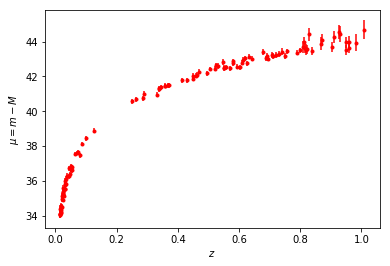

In [2]:
# Loading data
z_obs, m_obs, dm_obs_stat = np.loadtxt("Legacy.dat", unpack=True)

# Systematic error
dm_syst = 0.0169

# Combining errors
dm_obs = np.sqrt(dm_syst + dm_obs_stat ** 2)

# Checking
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu = m - M$")
plt.errorbar(z_obs, m_obs, dm_obs, fmt='r.' );

## Funções para modelar $\mu$ em função de $z$, $\Omega_{m0}$, $\alpha$ e $h$

In [3]:
def luminosity_integrand(z, omgM, alpha):
    Ez = np.power((1 - omgM) + omgM * np.power(1 + z, 3*(1+alpha)), 1./(2*(1+alpha)))
    return 1. / Ez

def luminosity_distance(z, h, omgM, alpha):
    integral, _ = quad(luminosity_integrand, 0, z, epsrel=1e-8, args=(omgM, alpha))
    return (cte.c / 10. ** 5) / h * (1 + z) * integral

def distance_modulus(z, h, omgM, alpha):
    return 5. * np.log10(luminosity_distance(z, h, omgM, alpha)) + 25.

## $\chi^2$ em função de $\Omega_{m0}$ e $\alpha$
(para o dataset carregado previamente)

In [4]:
def chisq(h, omgM, alpha):
    m_model = np.array([distance_modulus(z, h, omgM, alpha) for z in z_obs])
    chisq_vec = np.power(((m_model - m_obs) / dm_obs), 2)
    return chisq_vec.sum()

## Soluções de máxima verossimilhança

### Variando $\Omega_{m0}$, $h$ e $\alpha$
Aqui fixamos apenas $\Omega_{r0} = \Omega_{r0, fid} = 8.4 \cdot 10^{-5}$

In [5]:
h_fid = 0.73
omgM_fid = 0.3
alpha_fid = 0
chisq_gcg = lambda x: chisq(x[0], x[1], x[2])
result_gcg = minimize(chisq_gcg, [h_fid, omgM_fid, alpha_fid], bounds=((0.001, 1.), (0.001, 1.), (-1., 1.)))
h_gcg, omgM_gcg, alpha_gcg = result_gcg.x
print("Convergiu?: ", result_gcg.success)
print("chisq / dof = ", result_gcg.fun / (len(z_obs) - 3))
print("h = ", h_gcg)
print("omegaM = ",  omgM_gcg)
print("alpha = ", alpha_gcg)

/home/pedro/.virtualenvs/ex-cosmo/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


Convergiu?:  True
chisq / dof =  1.013542963618193
h =  0.7017463508751948
omegaM =  0.23232257792905575
alpha =  0.2556085772926484


Encontramos $\Omega_{m0, GCG} = 0.2323$, $h_{GCG} = 0.7017$ e $\alpha_{GCG} = 0.26$. $\chi^2_{red} = 1.01$

## Variando apenas $\Omega_{m0}$ e $h$ ($\Lambda$CDM)

In [6]:
h_fid = 0.73
omgM_fid = 0.3
alpha_fid = 0
chisq_lcdm = lambda x: chisq(x[0], x[1], 0)
result_lcdm = minimize(chisq_lcdm, [h_fid, omgM_fid], bounds=((0.001, 1.), (0.001, 1.)))
h_lcdm, omgM_lcdm = result_lcdm.x
print("Convergiu?: ", result_lcdm.success)
print("chisq / dof = ", result_lcdm.fun / (len(z_obs) - 2))
print("h_lcdm = ", h_lcdm)
print("omegaM_lcdm = ",  omgM_lcdm)

Convergiu?:  True
chisq / dof =  1.0049561283013675
h_lcdm =  0.7006890260864301
omegaM_lcdm =  0.26051412270110036


Encontramos $\Omega_{m0, \Lambda CDM} = 0.2605$, $h_{GCG} = 0.7007$. $\chi^2_{red} = 1.00$.

## Gráficos

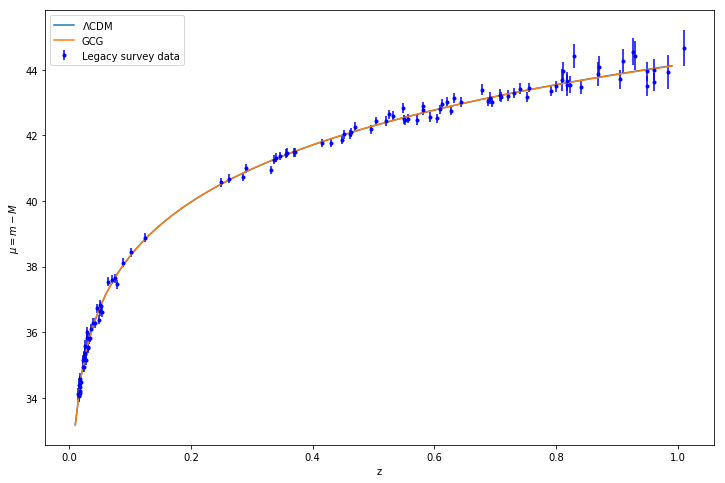

In [7]:
# Plots
zs = np.arange(0.01, 1.0, 0.01)
distance_modulus_lcdm = np.vectorize(lambda z : distance_modulus(z, h_lcdm, omgM_lcdm, 0.))
distance_modulus_gcg = np.vectorize(lambda z : distance_modulus(z, h_gcg, omgM_gcg, alpha_gcg))

plt.figure(figsize=(12, 8))
plt.xlabel("z")
plt.ylabel(r"$\mu = m - M$")
plt.plot(zs, distance_modulus_lcdm(zs), label=r"$\Lambda$CDM")
plt.plot(zs, distance_modulus_gcg(zs), label=r"GCG")
plt.errorbar(z_obs, m_obs, dm_obs, fmt='b.', label=r"Legacy survey data")
plt.legend();

## Probabilidades a posteriori

### Probabilidades a posteriori para $\Omega_{m0}$,  $h$ e $\alpha$ (GCG)

### MCMC

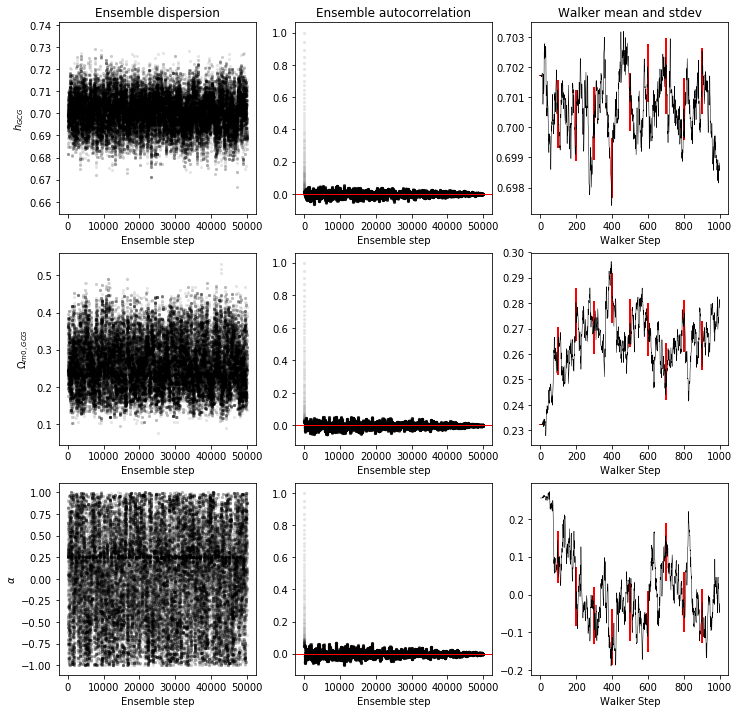

In [8]:
# Functions for priors and loglikelihoods
def lnprior(pars):
    h, omgM, alpha = pars
    if 0.0 < h and 0.0 < omgM < 1.0 and -1.0 < alpha < 1.0:
        return 0.0
    return -np.inf

def lnlike(pars):
    h, omgM, alpha = pars
    return -0.5 * chisq(h, omgM, alpha)

def lnprob(pars):
    lp = lnprior(pars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(pars)

# initial position at maximum likelihood values
ndim, nwalkers, nsteps = 3, 50, 1000
pos = [result_gcg.x + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# MCMC chain with 50 walkers and 1000 steps
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=4)
sampler.run_mcmc(pos, nsteps)

# Getting chains
h_chain = sampler.chain[:,:,0]
omgM_chain = sampler.chain[:,:,1]
alpha_chain = sampler.chain[:,:,2]

# Reshaping
h_chain_flat = np.reshape(h_chain, (nwalkers*nsteps,))
omgM_chain_flat = np.reshape(omgM_chain, (nwalkers*nsteps,))
alpha_chain_flat = np.reshape(alpha_chain, (nwalkers*nsteps,))

fig = plt.figure(figsize=(12, 12))
axs = fig.subplots(3, 3)

labels = [r"$h_{GCG}$", r"$\Omega_{m0,GCG}$", r"$\alpha$"]
samples = np.c_[h_chain_flat, omgM_chain_flat, alpha_chain_flat].T
for i, par in enumerate(samples):
    axs[i][0].set_xlabel("Ensemble step")
    axs[i][1].set_xlabel("Ensemble step")
    axs[i][2].set_xlabel("Walker Step")
    axs[i][0].set_ylabel(labels[i])
    axs[0][0].set_title("Ensemble dispersion")
    axs[0][1].set_title("Ensemble autocorrelation")
    axs[0][2].set_title("Walker mean and stdev")
    idx = np.arange(len(par))
    axs[i][0].scatter(idx, par[idx], marker='o', c='k', s=10.0, alpha=0.1, linewidth=0)
    # Obtem autocorrelação usando emcee
    ac = emcee.autocorr.function(par)

    idx = np.arange(len(ac),step=1)
    axs[i][1].scatter(idx, ac[idx], marker='o', c='k', s=10.0, alpha=0.1, linewidth=0)
    axs[i][1].axhline(alpha=1., lw=1., color='red')

# Average and standard deviation between chains
h_chain_mean = np.mean(h_chain, axis=0)
h_chain_err = np.std(h_chain, axis=0) / np.sqrt(nwalkers)
omgM_chain_mean = np.mean(omgM_chain, axis=0)
omgM_chain_err = np.std(omgM_chain, axis=0) / np.sqrt(nwalkers)
alpha_chain_mean = np.mean(alpha_chain, axis=0)
alpha_chain_err = np.std(alpha_chain, axis=0) / np.sqrt(nwalkers)
idx = np.arange(len(h_chain_mean))
axs[0][2].errorbar(x=idx, y=h_chain_mean, yerr=h_chain_err, errorevery=100, ecolor='red',
                   lw=0.5, elinewidth=2., color='k')
axs[1][2].errorbar(x=idx, y=omgM_chain_mean, yerr=omgM_chain_err, errorevery=100, ecolor='red',
                   lw=0.5, elinewidth=2., color='k');
axs[2][2].errorbar(x=idx, y=alpha_chain_mean, yerr=alpha_chain_err, errorevery=100, ecolor='red',
                   lw=0.5, elinewidth=2., color='k');

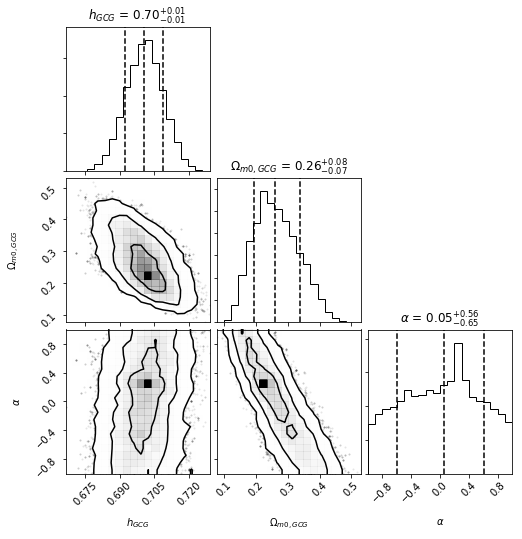

In [9]:
# corner plot
burn = 5000
samples_burned = np.c_[[par[burn:] for par in samples]]
fig = corner.corner(samples_burned.T, labels=labels,
                    quantiles=[0.16, 0.5, 0.84], 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2), 1-np.exp(-9./2)), #1sigma, 2sigma and 3sigma contours
                    show_titles=True, title_kwargs={"fontsize": 12},
                    smooth1d=None, plot_contours=True,
                    no_fill_contours=False, plot_density=True,)

In [10]:
# Getting one-sigma intervals
samples[:, 2] = np.exp(samples[:, 2])
h_perc = np.percentile(samples[0], [16,50,84])
omgM_perc = np.percentile(samples[1], [16,50,84])

print(h_perc[1], h_perc[0] - h_perc[1], h_perc[2] - h_perc[1])
print(omgM_perc[1], omgM_perc[0] - omgM_perc[1], omgM_perc[2] - omgM_perc[1])

0.7007819177547232 -0.008276079323346064 0.007906554227553597
0.2582305871243836 -0.0657552286865718 0.08039457898630692


$h = 0.7008^{+0.0079}_{-0.0083} \qquad \Omega_{m0} = 0.258^{+0.080}_{-0.065}$

## Fatores de Bayes e Evidências

In [17]:
def prior_gcg(cube, ndim, nparams):
    cube[0] = cube[0]  # h between 0. and 1.
    cube[1] = cube[1]  # omgM between 0. and 1.
    cube[2] = 2.*cube[2] - 1.  # alpha between -1 and 1

def loglike_gcg(cube, ndim, nparams):
    return lnlike([cube[0], cube[1], cube[2]])

parameters_gcg = ["$h_{GCG}$", "$\Omega_{m0,GCG}$", "$alpha_{GCG}$"]
nparams_gcg = len(parameters_gcg)
outputfiles_gcg = "./multinest_ex7/gcg"

mn.run(loglike_gcg, prior_gcg, nparams_gcg, sampling_efficiency=0.3, evidence_tolerance=0.5, verbose=True,
       outputfiles_basename=outputfiles_gcg)

def prior_lcdm(cube, ndim, nparams):
    cube[0] = cube[0]  # h between 0. and 1.
    cube[1] = cube[1]  # omgM between 0. and 1.

def loglike_lcdm(cube, ndim, nparams):
    return lnlike([cube[0], cube[1], 0.])

parameters_lcdm = ["$h_{GCG}$", "$\Omega_{m0,GCG}$"]
nparams_lcdm = len(parameters_lcdm)
outputfiles_lcdm = "./multinest_ex7/lcdm"

mn.run(loglike_lcdm, prior_lcdm, nparams_lcdm, sampling_efficiency=0.3, evidence_tolerance=0.5, verbose=True,
       outputfiles_basename=outputfiles_lcdm)

In [18]:
analyzer_gcg = mn.Analyzer(outputfiles_basename=outputfiles_gcg, n_params = nparams_gcg)
analyzer_gcg.get_stats()

analyzer_lcdm = mn.Analyzer(outputfiles_basename=outputfiles_lcdm, n_params = nparams_lcdm)
analyzer_lcdm.get_stats()

  analysing data from ./multinest_ex7/gcg.txt
  analysing data from ./multinest_ex7/lcdm.txt


{'global evidence': -63.650396697334365,
 'global evidence error': 0.0198670440975684,
 'marginals': [{'1sigma': [0.6924125525368008, 0.7090967053702805],
   '2sigma': [0.6849075251646054, 0.7167277464639813],
   '3sigma': [0.6768332622122959, 0.7234609154230643],
   '5sigma': [0.6621752302712541, 0.7392834706109492],
   'median': 0.700582394930083,
   'q01%': 0.6817496358518175,
   'q10%': 0.6897795801410136,
   'q25%': 0.6949817517929211,
   'q75%': 0.7064605719855981,
   'q90%': 0.7110278688756178,
   'q99%': 0.718884772989347,
   'sigma': 0.008342076416739841},
  {'1sigma': [0.2261734022587374, 0.29994715363314767],
   '2sigma': [0.1912558568721496, 0.33677643561391385],
   '3sigma': [0.1619629623313758, 0.3823525165705669],
   '5sigma': [0.1050614567474555, 0.46406654271660075],
   'median': 0.26103015591993606,
   'q01%': 0.1786670585349242,
   'q10%': 0.21625609345736307,
   'q25%': 0.2376927136007021,
   'q75%': 0.28889615664224766,
   'q90%': 0.30992881220277585,
   'q99%': 0.

## Contour plot for GCG (Multinest sampler)

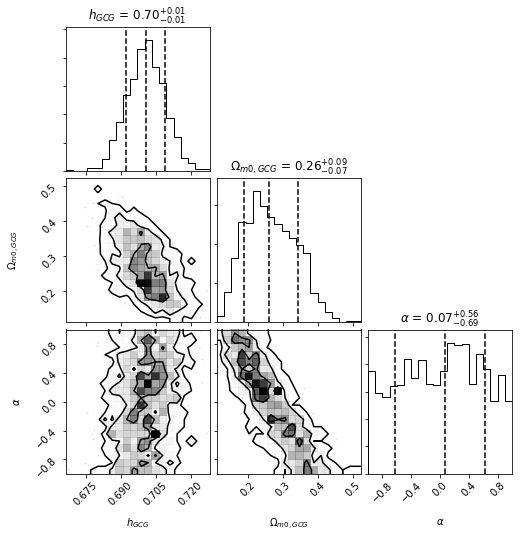

In [19]:
mn_chain = analyzer_gcg.get_equal_weighted_posterior()
fig = corner.corner(mn_chain[:,:3], labels=labels,
                    quantiles=[0.16, 0.5, 0.84], 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2), 1-np.exp(-9./2)), #1sigma, 2sigma and 3sigma contours
                    show_titles=True, title_kwargs={"fontsize": 12},
                    smooth1d=None, plot_contours=True,
                    no_fill_contours=False, plot_density=True,)

## Contour plot for $\Lambda CDM$ (Multinest sampler)

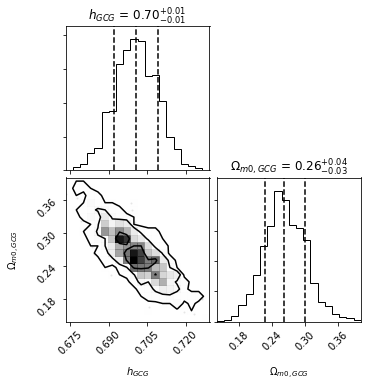

In [20]:
mn_chain = analyzer_lcdm.get_equal_weighted_posterior()
fig = corner.corner(mn_chain[:,:2], labels=labels[:2],
                    quantiles=[0.16, 0.5, 0.84], 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2), 1-np.exp(-9./2)), #1sigma, 2sigma and 3sigma contours
                    show_titles=True, title_kwargs={"fontsize": 12},
                    smooth1d=None, plot_contours=True,
                    no_fill_contours=False, plot_density=True,)

In [21]:
lnK_gcg = analyzer_gcg.get_stats()["global evidence"]
lnK_gcg_err = analyzer_gcg.get_stats()["global evidence error"]
lnK_lcdm = analyzer_lcdm.get_stats()["global evidence"]
lnK_lcdm_err = analyzer_lcdm.get_stats()["global evidence error"]

K = np.exp(lnK_lcdm - lnK_gcg)
err_K = K * np.sqrt(lnK_gcg_err ** 2 + lnK_lcdm_err ** 2)
print("Bayes Factor (in favor of LCDM) = %.2f +/- %.2f" % (K, err_K))

Bayes Factor (in favor of LCDM) = 1.44 +/- 0.04


* A análise do Gás de Chaplygin é consistente com $\alpha = 0$.

* O fator de Bayes favorece $\Lambda CDM$, embora muito modestamente. Naturalmente a interpretação de qual é a chance a posteriori de cada modelo depende da expectativa a priori.

* Os resultados podem depender da calibração das supernovas.